**WEEK - 4**

**Step 1.Mount Google Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**HYPERPARAMETERS**

In [6]:
# ------------------- IMPORTS -------------------
import os, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ------------------- HYPERPARAMETERS -------------------
HYPERPARAMS = {
    "img_height": 256,
    "img_width": 256,
    "batch_size": 16,        # increased
    "epochs": 30,            # increased
    "limit": 400,
    "seed": 42,
    "learning_rate": 1e-4,
    "optimizer": "Adam",
    "dropout_rate": 0.5
}

IMG_H, IMG_W = HYPERPARAMS["img_height"], HYPERPARAMS["img_width"]
BATCH_SIZE   = HYPERPARAMS["batch_size"]
EPOCHS       = HYPERPARAMS["epochs"]
LIMIT        = HYPERPARAMS["limit"]
SEED         = HYPERPARAMS["seed"]

# ------------------- PATHS -------------------
IMAGE_DIR = "/content/drive/MyDrive/VisionExtract/data/coco2017/original_images"
MASK_DIR  = "/content/drive/MyDrive/VisionExtract/data/coco2017/train_masks"

# ------------------- PAIRING IMAGES AND MASKS -------------------
def get_pairs(img_dir, mask_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    mask_set = set(mask_files)
    pairs = []
    for img in img_files:
        stem = os.path.splitext(img)[0]
        expected_mask = stem + "_mask.png"
        if expected_mask in mask_set:
            pairs.append((os.path.join(img_dir, img), os.path.join(mask_dir, expected_mask)))
    return pairs

pairs = get_pairs(IMAGE_DIR, MASK_DIR)
print("Total pairs found:", len(pairs))
if len(pairs) == 0:
    raise RuntimeError("No image-mask pairs found. Check file names (_mask.png).")

if LIMIT:
    pairs = pairs[:LIMIT]

random.seed(SEED)
random.shuffle(pairs)

# ------------------- LOADING DATA -------------------
def load_pairs_to_numpy(pairs, img_h=IMG_H, img_w=IMG_W):
    X, Y = [], []
    for img_path, mask_path in pairs:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_w, img_h))
        img = preprocess_input(img.astype(np.float32))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)
        mask = mask[..., np.newaxis]

        X.append(img)
        Y.append(mask.astype(np.float32))
    return np.stack(X, axis=0), np.stack(Y, axis=0)

X_train, y_train = load_pairs_to_numpy(pairs)
print("Loaded X_train:", X_train.shape, "y_train:", y_train.shape)

# ------------------- LOSS + METRICS -------------------
def dice_coef_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss_tf(y_true, y_pred):
    return 1.0 - dice_coef_tf(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()
def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss_tf(y_true, y_pred)

class PixelAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='pixel_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
        y_true_f = tf.cast(y_true, tf.float32)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_bin), tf.float32))
        total = tf.cast(tf.size(y_true_f), tf.float32)
        self.correct.assign_add(correct)
        self.total.assign_add(total)
    def result(self):
        return self.correct / (self.total + 1e-8)
    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

# ------------------- BUILD U-NET -------------------
def build_unet_resnet50(input_shape=(IMG_H, IMG_W, 3), backbone_trainable=False, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)
    backbone = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    backbone.trainable = backbone_trainable

    c1 = backbone.get_layer("conv1_relu").output
    c2 = backbone.get_layer("conv2_block3_out").output
    c3 = backbone.get_layer("conv3_block4_out").output
    c4 = backbone.get_layer("conv4_block6_out").output
    c5 = backbone.get_layer("conv5_block3_out").output

    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D(size=(2,2))(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    d4 = decoder_block(c5, c4, 512)
    d3 = decoder_block(d4, c3, 256)
    d2 = decoder_block(d3, c2, 128)
    d1 = decoder_block(d2, c1, 64)

    x = layers.UpSampling2D(size=(2,2))(d1)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

# ------------------- OPTIMIZER -------------------
if HYPERPARAMS["optimizer"] == "Adam":
    optimizer = Adam(learning_rate=HYPERPARAMS["learning_rate"])
elif HYPERPARAMS["optimizer"] == "SGD":
    optimizer = SGD(learning_rate=HYPERPARAMS["learning_rate"], momentum=0.9)
elif HYPERPARAMS["optimizer"] == "RMSprop":
    optimizer = RMSprop(learning_rate=HYPERPARAMS["learning_rate"])

# ------------------- MODEL -------------------
model = build_unet_resnet50(
    input_shape=(IMG_H, IMG_W, 3),
    backbone_trainable=False,
    dropout_rate=HYPERPARAMS["dropout_rate"]
)
model.compile(optimizer=optimizer, loss=bce_dice_loss,
              metrics=[PixelAccuracy(), MeanIoU(num_classes=2)])
model.summary()

# ------------------- CALLBACKS -------------------
callbacks = [
    EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("unet_resnet50_best.h5", monitor="loss", save_best_only=True, verbose=1)
]

# ------------------- TRAINING -------------------
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    callbacks=callbacks
)


Total pairs found: 157
Loaded X_train: (157, 256, 256, 3) y_train: (157, 256, 256, 1)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 47,128,385 (179.78 MB)

 Trainable params: 23,540,673 (89.80 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.6872 - mean_io_u: 0.3841 - pixel_accuracy: 0.4679   
Epoch 1: loss improved from inf to 1.52154, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - loss: 1.6721 - mean_io_u: 0.3834 - pixel_accuracy: 0.4763 - learning_rate: 1.0000e-04
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 1.2837 - mean_io_u: 0.3754 - pixel_accuracy: 0.6914
Epoch 2: loss improved from 1.52154 to 1.21023, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 503ms/step - loss: 1.2771 - mean_io_u: 0.3754 - pixel_accuracy: 0.6934 - learning_rate: 1.0000e-04
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.9115 - mean_io_u: 0.3826 - pixel_accuracy: 0.7968
Epoch 3: loss improved from 1.21023 to 0.89343, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 544ms/step - loss: 0.9098 - mean_io_u: 0.3820 - pixel_accuracy: 0.7962 - learning_rate: 1.0000e-04
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.6073 - mean_io_u: 0.3685 - pixel_accuracy: 0.8809
Epoch 4: loss improved from 0.89343 to 0.61061, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - loss: 0.6076 - mean_io_u: 0.3692 - pixel_accuracy: 0.8813 - learning_rate: 1.0000e-04
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 0.5040 - mean_io_u: 0.3745 - pixel_accuracy: 0.9070
Epoch 5: loss improved from 0.61061 to 0.49765, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step - loss: 0.5034 - mean_io_u: 0.3746 - pixel_accuracy: 0.9071 - learning_rate: 1.0000e-04
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.3981 - mean_io_u: 0.3785 - pixel_accuracy: 0.9327
Epoch 6: loss improved from 0.49765 to 0.37666, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - loss: 0.3962 - mean_io_u: 0.3783 - pixel_accuracy: 0.9328 - learning_rate: 1.0000e-04
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 0.2809 - mean_io_u: 0.3745 - pixel_accuracy: 0.9493
Epoch 7: loss improved from 0.37666 to 0.29398, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - loss: 0.2821 - mean_io_u: 0.3747 - pixel_accuracy: 0.9491 - learning_rate: 1.0000e-04
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.2588 - mean_io_u: 0.3807 - pixel_accuracy: 0.9534
Epoch 8: loss improved from 0.29398 to 0.24397, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - loss: 0.2574 - mean_io_u: 0.3804 - pixel_accuracy: 0.9536 - learning_rate: 1.0000e-04
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 0.2076 - mean_io_u: 0.3840 - pixel_accuracy: 0.9637
Epoch 9: loss improved from 0.24397 to 0.20426, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step - loss: 0.2073 - mean_io_u: 0.3835 - pixel_accuracy: 0.9636 - learning_rate: 1.0000e-04
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.1699 - mean_io_u: 0.3838 - pixel_accuracy: 0.9686
Epoch 10: loss improved from 0.20426 to 0.16826, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 490ms/step - loss: 0.1697 - mean_io_u: 0.3838 - pixel_accuracy: 0.9687 - learning_rate: 1.0000e-04
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.1501 - mean_io_u: 0.3783 - pixel_accuracy: 0.9718
Epoch 11: loss improved from 0.16826 to 0.15157, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - loss: 0.1502 - mean_io_u: 0.3790 - pixel_accuracy: 0.9718 - learning_rate: 1.0000e-04
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.1332 - mean_io_u: 0.3955 - pixel_accuracy: 0.9750
Epoch 12: loss improved from 0.15157 to 0.13390, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - loss: 0.1333 - mean_io_u: 0.3958 - pixel_accuracy: 0.9750 - learning_rate: 1.0000e-04
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.1341 - mean_io_u: 0.3918 - pixel_accuracy: 0.9748
Epoch 13: loss improved from 0.13390 to 0.13095, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 489ms/step - loss: 0.1338 - mean_io_u: 0.3924 - pixel_accuracy: 0.9749 - learning_rate: 1.0000e-04
Epoch 14/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.1219 - mean_io_u: 0.4238 - pixel_accuracy: 0.9772
Epoch 14: loss improved from 0.13095 to 0.12206, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - loss: 0.1219 - mean_io_u: 0.4235 - pixel_accuracy: 0.9772 - learning_rate: 1.0000e-04
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 0.1153 - mean_io_u: 0.4147 - pixel_accuracy: 0.9779
Epoch 15: loss improved from 0.12206 to 0.11705, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - loss: 0.1154 - mean_io_u: 0.4155 - pixel_accuracy: 0.9779 - learning_rate: 1.0000e-04
Epoch 16/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.1130 - mean_io_u: 0.4106 - pixel_accuracy: 0.9780
Epoch 16: loss improved from 0.11705 to 0.11053, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - loss: 0.1127 - mean_io_u: 0.4119 - pixel_accuracy: 0.9781 - learning_rate: 1.0000e-04
Epoch 17/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.0975 - mean_io_u: 0.4413 - pixel_accuracy: 0.9812
Epoch 17: loss improved from 0.11053 to 0.09631, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - loss: 0.0974 - mean_io_u: 0.4418 - pixel_accuracy: 0.9812 - learning_rate: 1.0000e-04
Epoch 18/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0964 - mean_io_u: 0.4492 - pixel_accuracy: 0.9814
Epoch 18: loss improved from 0.09631 to 0.09207, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - loss: 0.0960 - mean_io_u: 0.4500 - pixel_accuracy: 0.9815 - learning_rate: 1.0000e-04
Epoch 19/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0869 - mean_io_u: 0.4643 - pixel_accuracy: 0.9838
Epoch 19: loss improved from 0.09207 to 0.08949, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 531ms/step - loss: 0.0871 - mean_io_u: 0.4645 - pixel_accuracy: 0.9837 - learning_rate: 1.0000e-04
Epoch 20/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 0.0918 - mean_io_u: 0.4573 - pixel_accuracy: 0.9825
Epoch 20: loss improved from 0.08949 to 0.08844, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - loss: 0.0915 - mean_io_u: 0.4586 - pixel_accuracy: 0.9825 - learning_rate: 1.0000e-04
Epoch 21/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.0870 - mean_io_u: 0.4737 - pixel_accuracy: 0.9834
Epoch 21: loss improved from 0.08844 to 0.08802, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - loss: 0.0871 - mean_io_u: 0.4727 - pixel_accuracy: 0.9834 - learning_rate: 1.0000e-04
Epoch 22/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.0823 - mean_io_u: 0.4943 - pixel_accuracy: 0.9839
Epoch 22: loss improved from 0.08802 to 0.08503, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 0.0826 - mean_io_u: 0.4934 - pixel_accuracy: 0.9838 - learning_rate: 1.0000e-04
Epoch 23/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0818 - mean_io_u: 0.4650 - pixel_accuracy: 0.9837
Epoch 23: loss improved from 0.08503 to 0.08104, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - loss: 0.0818 - mean_io_u: 0.4665 - pixel_accuracy: 0.9838 - learning_rate: 1.0000e-04
Epoch 24/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0730 - mean_io_u: 0.5151 - pixel_accuracy: 0.9858
Epoch 24: loss improved from 0.08104 to 0.07745, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - loss: 0.0734 - mean_io_u: 0.5150 - pixel_accuracy: 0.9857 - learning_rate: 1.0000e-04
Epoch 25/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.0729 - mean_io_u: 0.4681 - pixel_accuracy: 0.9864
Epoch 25: loss improved from 0.07745 to 0.07517, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - loss: 0.0731 - mean_io_u: 0.4700 - pixel_accuracy: 0.9863 - learning_rate: 1.0000e-04
Epoch 26/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0779 - mean_io_u: 0.5161 - pixel_accuracy: 0.9845
Epoch 26: loss improved from 0.07517 to 0.07314, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 498ms/step - loss: 0.0775 - mean_io_u: 0.5172 - pixel_accuracy: 0.9846 - learning_rate: 1.0000e-04
Epoch 27/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0758 - mean_io_u: 0.5486 - pixel_accuracy: 0.9851
Epoch 27: loss did not improve from 0.07314
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - loss: 0.0758 - mean_io_u: 0.5465 - pixel_accuracy: 0.9851 - learning_rate: 1.0000e-04
Epoch 28/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.0714 - mean_io_u: 0.4988 - pixel_accuracy: 0.9866
Epoch 28: loss improved from 0.07314 to 0.07157, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - loss: 0.0715 - mean_io_u: 0.4997 - pixel_accuracy: 0.9865 - learning_rate: 1.0000e-04
Epoch 29/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0702 - mean_io_u: 0.4960 - pixel_accuracy: 0.9866
Epoch 29: loss improved from 0.07157 to 0.06698, saving model to unet_resnet50_best.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - loss: 0.0699 - mean_io_u: 0.4972 - pixel_accuracy: 0.9866 - learning_rate: 1.0000e-04
Epoch 30/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.0653 - mean_io_u: 0.5394 - pixel_accuracy: 0.9875
Epoch 30: loss did not improve from 0.06698
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - loss: 0.0656 - mean_io_u: 0.5390 - pixel_accuracy: 0.9874 - learning_rate: 1.0000e-04


In [7]:
model.save("unet_resnet50_best.keras")

**Step 1:Load your dataset**

In [8]:
import os, random
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

IMAGE_DIR = "/content/drive/MyDrive/VisionExtract/data/coco2017/original_images"
MASK_DIR  = "/content/drive/MyDrive/VisionExtract/data/coco2017/train_masks"
IMG_H, IMG_W = 256, 256
SEED = 42
LIMIT = 400

# Pair images with masks
def get_pairs(img_dir, mask_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    mask_set = set(mask_files)
    pairs = []
    for img in img_files:
        stem = os.path.splitext(img)[0]
        expected_mask = stem + "_mask.png"
        if expected_mask in mask_set:
            pairs.append((os.path.join(img_dir, img), os.path.join(mask_dir, expected_mask)))
    return pairs

pairs = get_pairs(IMAGE_DIR, MASK_DIR)
if LIMIT:
    pairs = pairs[:LIMIT]

random.seed(SEED)
random.shuffle(pairs)

# Load images and masks
def load_pairs_to_numpy(pairs, img_h=IMG_H, img_w=IMG_W):
    X, Y = [], []
    for img_path, mask_path in pairs:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_w, img_h))
        img = preprocess_input(img.astype(np.float32))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)
        mask = mask[..., np.newaxis]

        X.append(img)
        Y.append(mask.astype(np.float32))
    return np.stack(X, axis=0), np.stack(Y, axis=0)

X_train, y_train = load_pairs_to_numpy(pairs)
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)


X_train shape: (157, 256, 256, 3) y_train shape: (157, 256, 256, 1)


**Step 2:Rebuild your U-Net model**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50

# Define Dice + BCE loss and PixelAccuracy metric (same as before)
def dice_coef_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss_tf(y_true, y_pred):
    return 1.0 - dice_coef_tf(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()
def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss_tf(y_true, y_pred)

class PixelAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='pixel_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
        y_true_f = tf.cast(y_true, tf.float32)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_bin), tf.float32))
        total = tf.cast(tf.size(y_true_f), tf.float32)
        self.correct.assign_add(correct)
        self.total.assign_add(total)
    def result(self):
        return self.correct / (self.total + 1e-8)
    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

# Build U-Net with ResNet50 backbone
def build_unet_resnet50(input_shape=(IMG_H, IMG_W, 3), backbone_trainable=False, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)
    backbone = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    backbone.trainable = backbone_trainable

    c1 = backbone.get_layer("conv1_relu").output
    c2 = backbone.get_layer("conv2_block3_out").output
    c3 = backbone.get_layer("conv3_block4_out").output
    c4 = backbone.get_layer("conv4_block6_out").output
    c5 = backbone.get_layer("conv5_block3_out").output

    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D(size=(2,2))(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    d4 = decoder_block(c5, c4, 512)
    d3 = decoder_block(d4, c3, 256)
    d2 = decoder_block(d3, c2, 128)
    d1 = decoder_block(d2, c1, 64)

    x = layers.UpSampling2D(size=(2,2))(d1)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

# Compile model
optimizer = Adam(learning_rate=1e-4)
model = build_unet_resnet50()
model.compile(optimizer=optimizer, loss=bce_dice_loss,
              metrics=[PixelAccuracy(), MeanIoU(num_classes=2)])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 47,128,385 (179.78 MB)

 Trainable params: 23,540,673 (89.80 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Step 3:Load your saved model**

In [10]:
from tensorflow.keras.models import load_model

# If you saved using ModelCheckpoint("unet_resnet50_best.keras")
model = load_model("/content/drive/MyDrive/VisionExtract/unet_resnet50_best.keras",
                   custom_objects={'bce_dice_loss': bce_dice_loss, 'PixelAccuracy': PixelAccuracy})


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


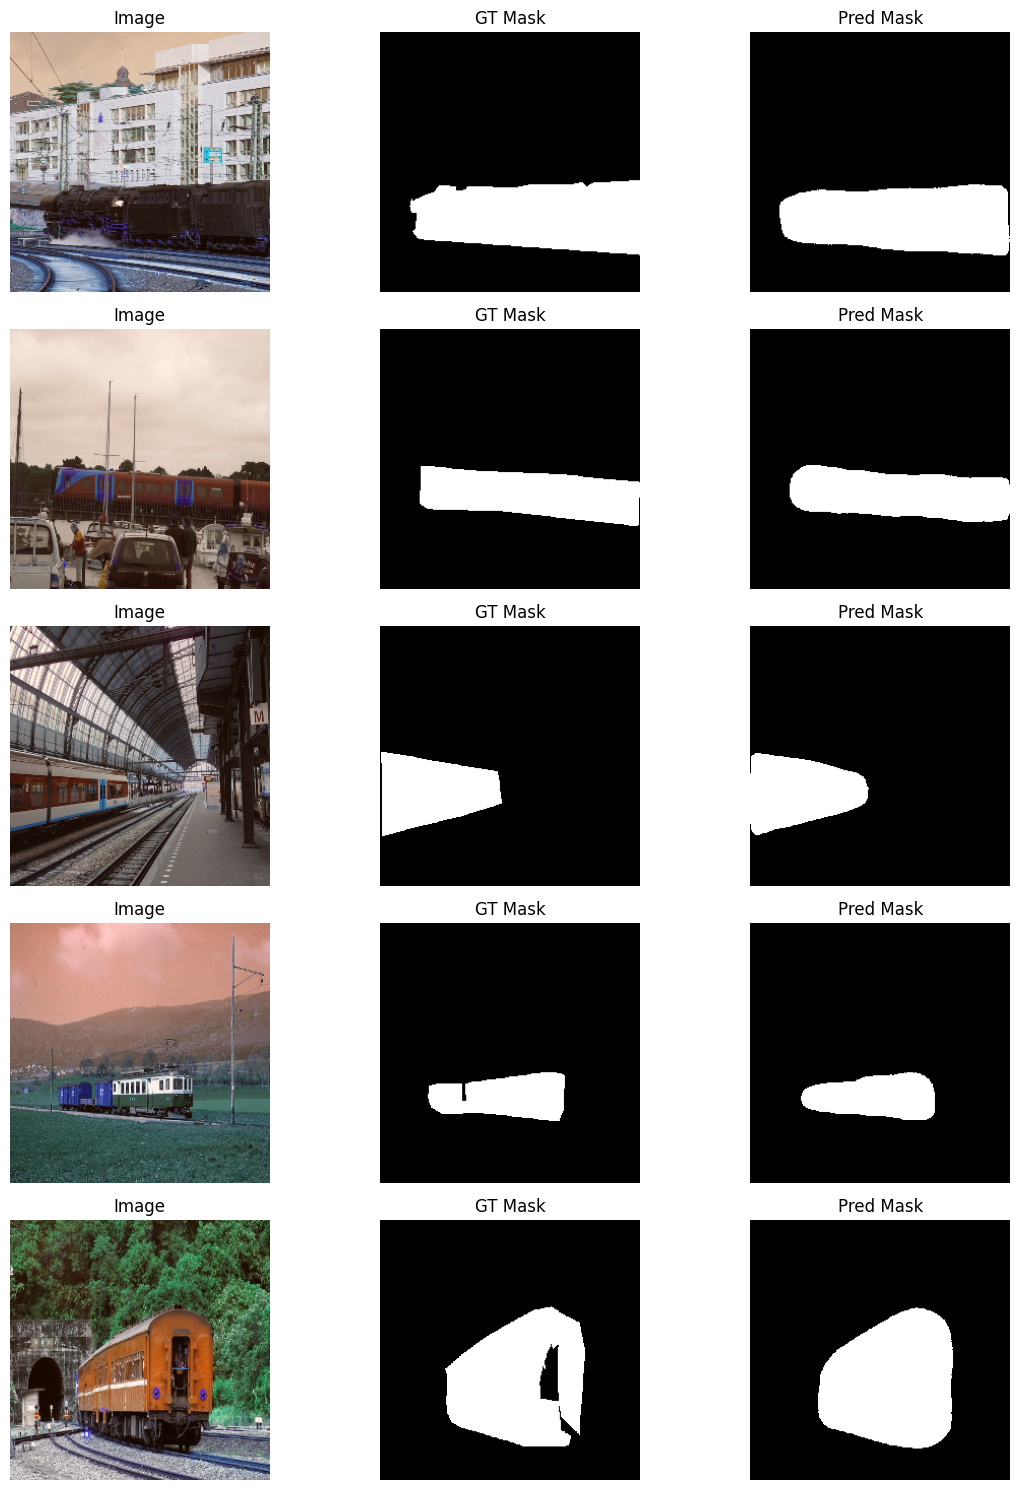

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to show
num_show = min(5, X_train.shape[0])
indices = np.random.choice(X_train.shape[0], num_show, replace=False)

# Get predictions
preds = model.predict(X_train[indices])
pred_bins = (preds > 0.5).astype(np.uint8)  # convert to binary masks

plt.figure(figsize=(12, num_show*3))

for i, idx in enumerate(indices):
    # Original image for display
    img_disp = X_train[idx].copy()
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)  # scale to 0..1

    # Plot original image
    plt.subplot(num_show, 3, i*3 + 1)
    plt.imshow(img_disp)
    plt.title("Image")
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(num_show, 3, i*3 + 2)
    plt.imshow(y_train[idx].squeeze(), cmap='gray')
    plt.title("GT Mask")
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(num_show, 3, i*3 + 3)
    plt.imshow(pred_bins[i].squeeze(), cmap='gray')
    plt.title("Pred Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


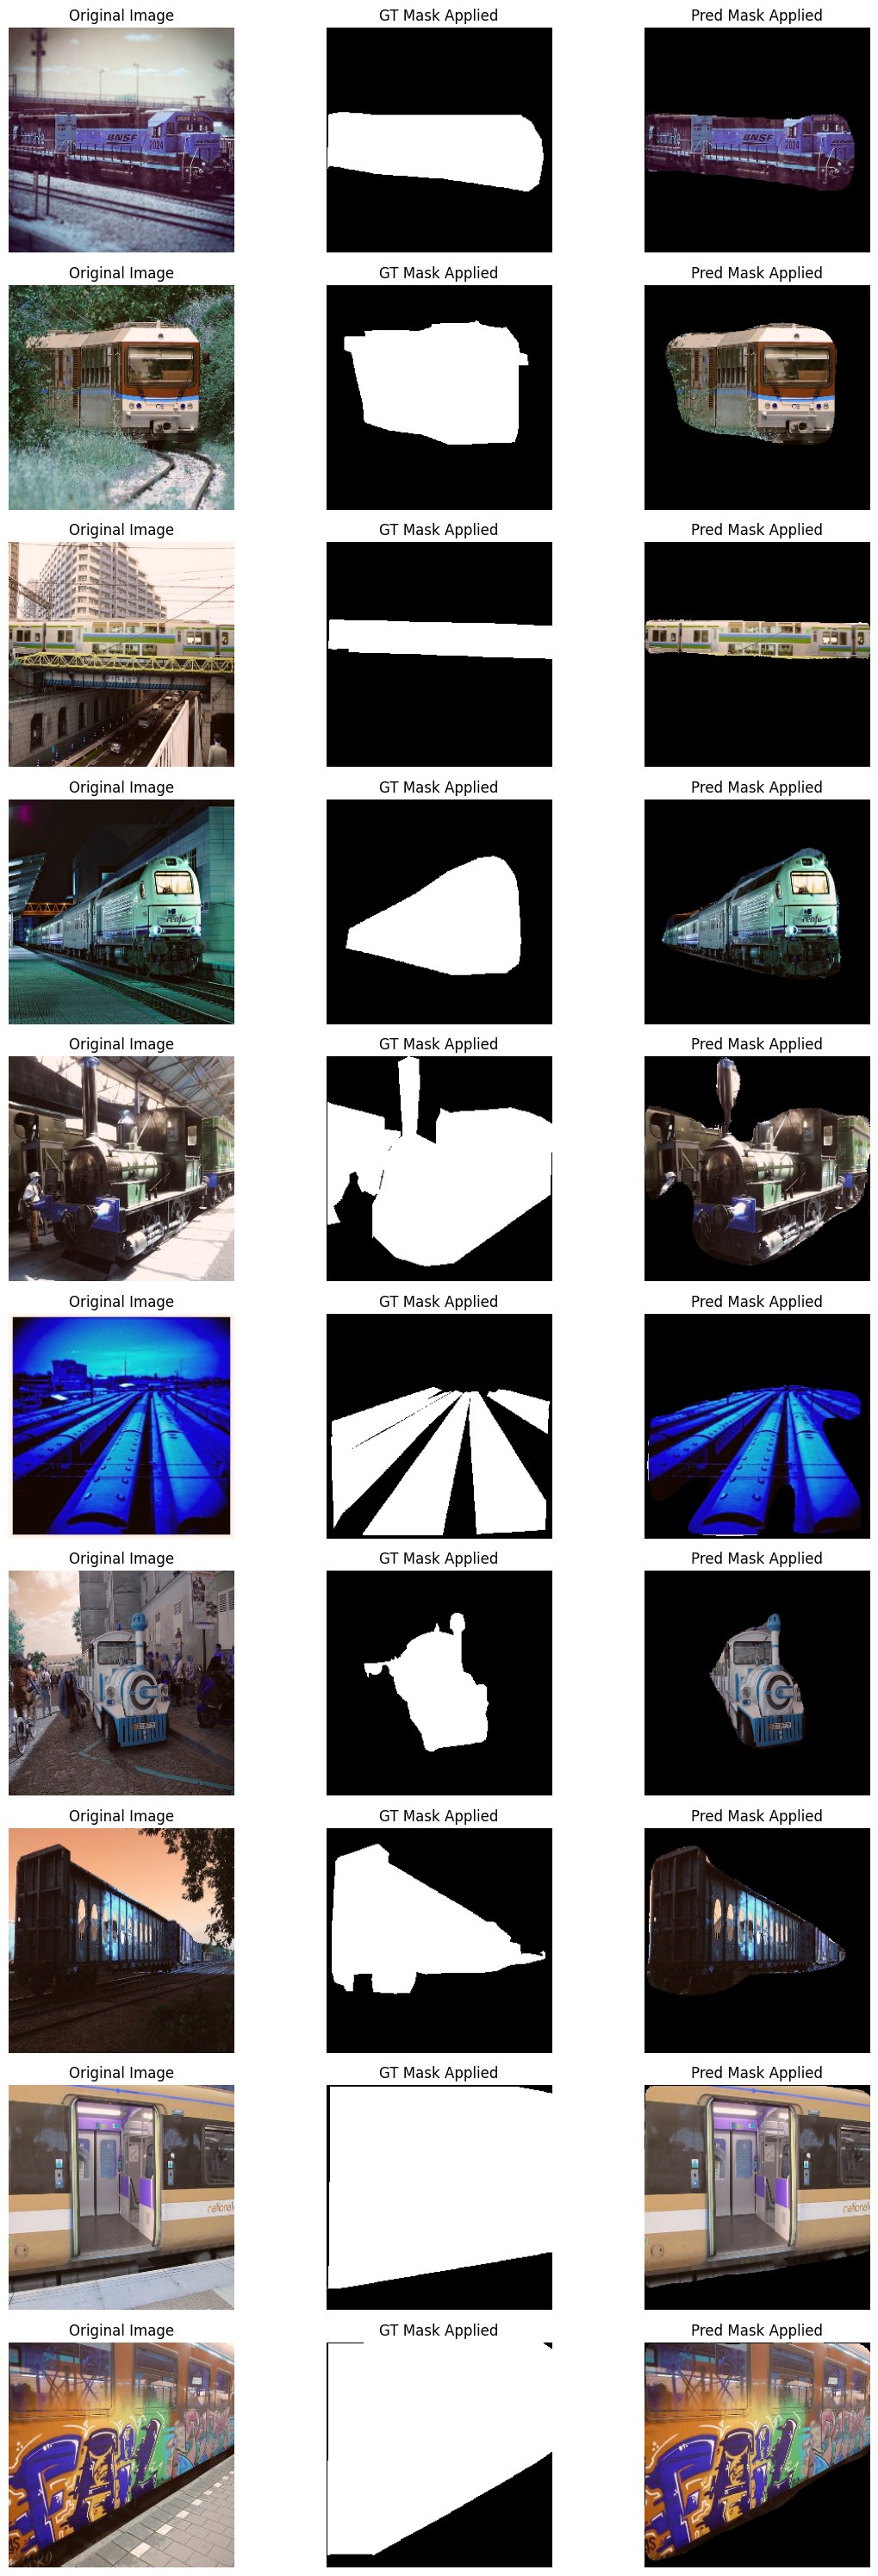

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to show (now 10 instead of 5)
num_show = min(10, X_train.shape[0])
indices = np.random.choice(X_train.shape[0], num_show, replace=False)

# Get predictions
preds = model.predict(X_train[indices])
pred_bins = (preds > 0.5).astype(np.uint8)  # convert to binary masks

plt.figure(figsize=(12, num_show*3))

for i, idx in enumerate(indices):
    # Original image for display
    img_disp = X_train[idx].copy()
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)  # scale to 0..1

    # Ground truth mask (binary)
    gt_mask = y_train[idx].squeeze()

    # Pred masked image (applied like before)
    pred_mask = pred_bins[i].squeeze()
    if img_disp.shape[-1] == 1:  # grayscale → make RGB
        img_disp_rgb = np.repeat(img_disp, 3, axis=-1)
        pred_masked_img = np.zeros_like(img_disp_rgb)
        pred_masked_img[pred_mask == 1] = img_disp_rgb[pred_mask == 1]
    else:
        pred_masked_img = np.zeros_like(img_disp)
        pred_masked_img[pred_mask == 1] = img_disp[pred_mask == 1]

    # Plot original image
    plt.subplot(num_show, 3, i*3 + 1)
    plt.imshow(img_disp.squeeze(), cmap='gray' if img_disp.shape[-1]==1 else None)
    plt.title("Original Image")
    plt.axis('off')

    # Plot GT mask directly in black & white
    plt.subplot(num_show, 3, i*3 + 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("GT Mask Applied")
    plt.axis('off')

    # Plot Pred-masked image
    plt.subplot(num_show, 3, i*3 + 3)
    plt.imshow(pred_masked_img)
    plt.title("Pred Mask Applied")
    plt.axis('off')

plt.tight_layout()
plt.show()
